# Ideal Parameter Analysis ($\delta=2.25$, $\tau=0.75$, $\alpha=2$) ($\tau$ upper bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.75
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

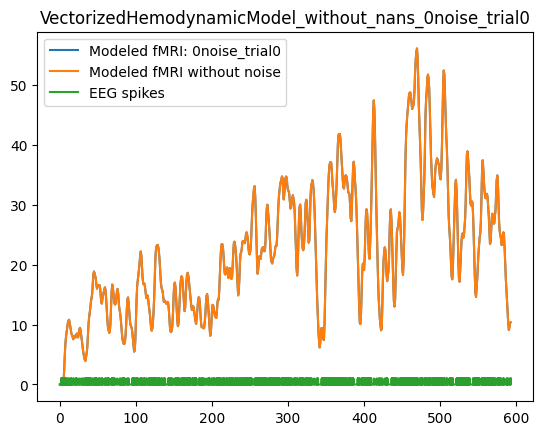

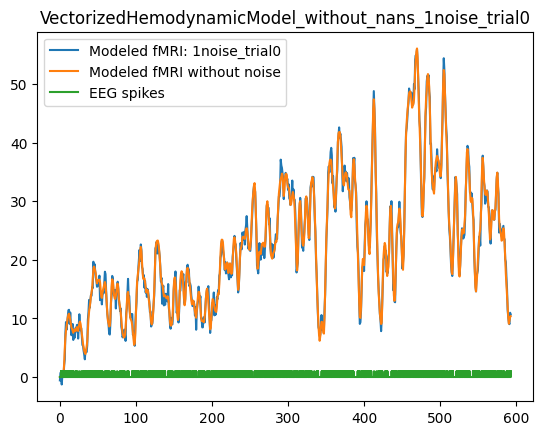

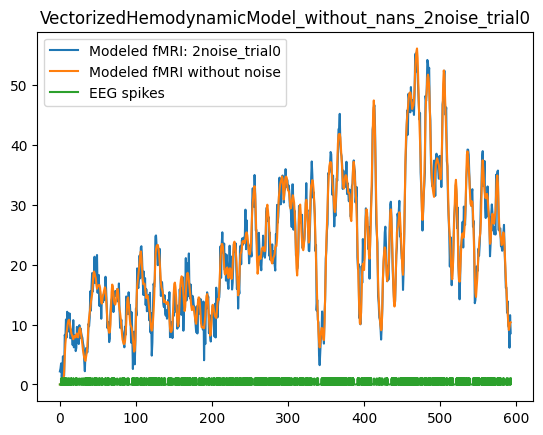

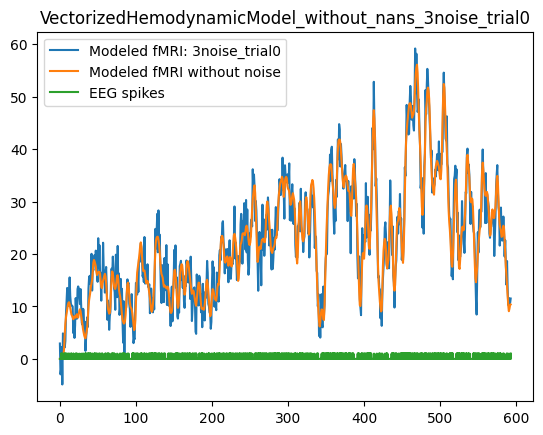

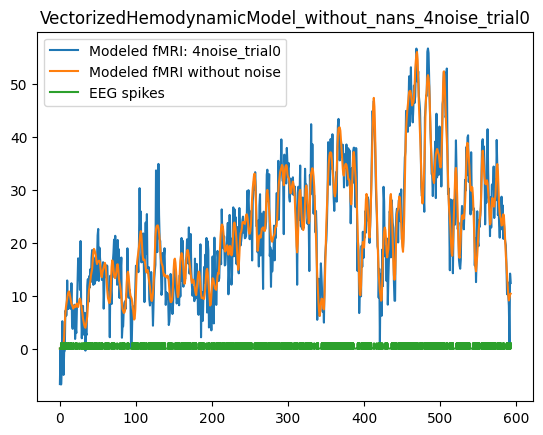

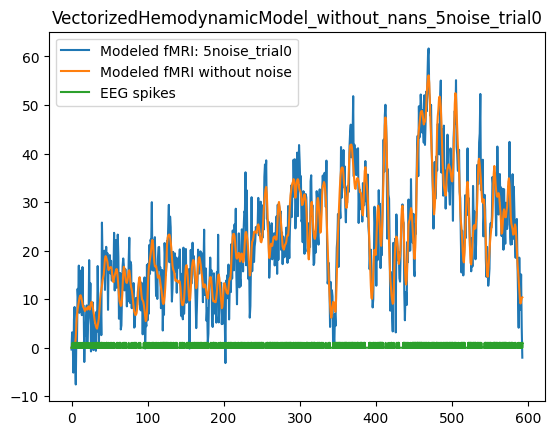

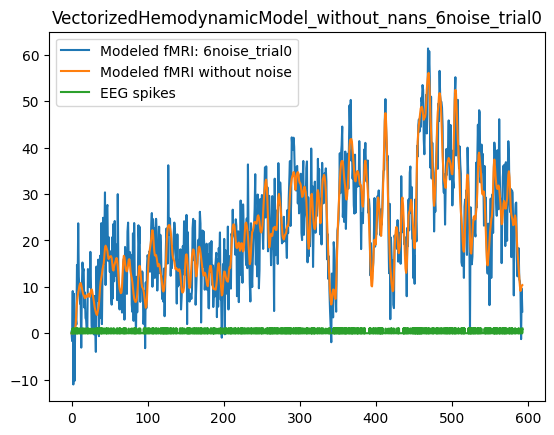

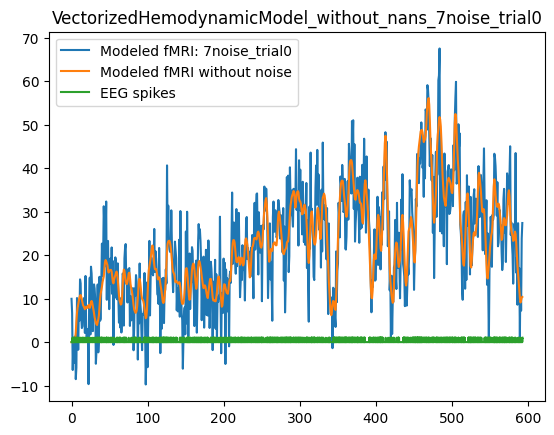

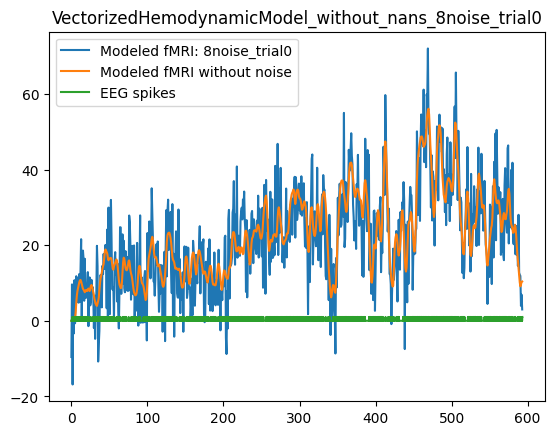

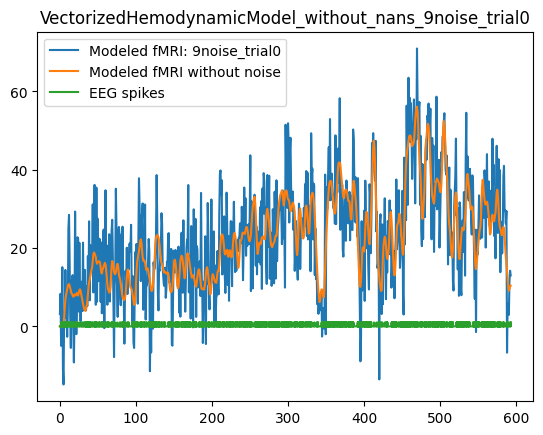

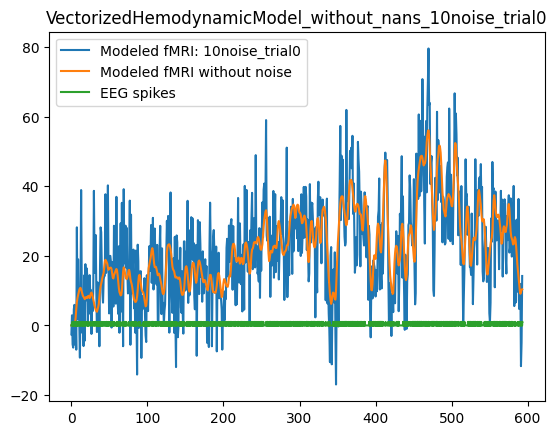

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.75, alpha=2


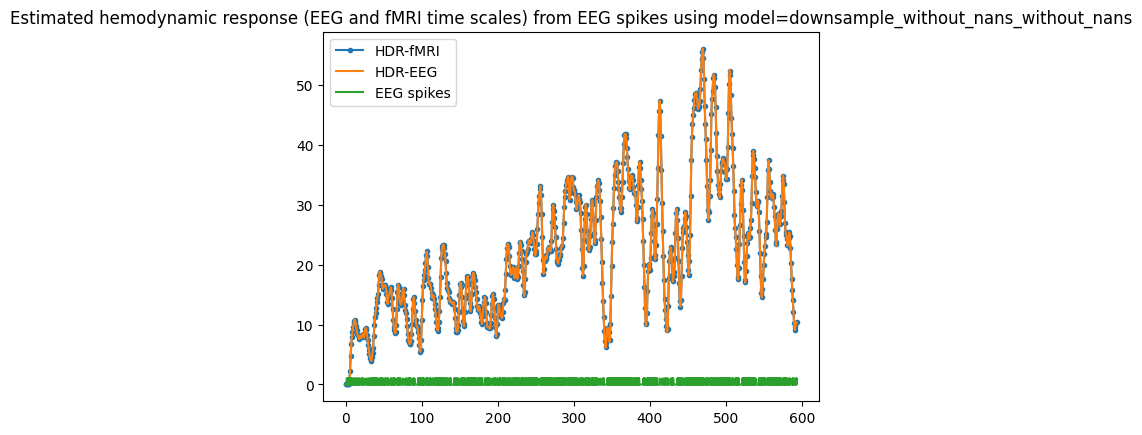

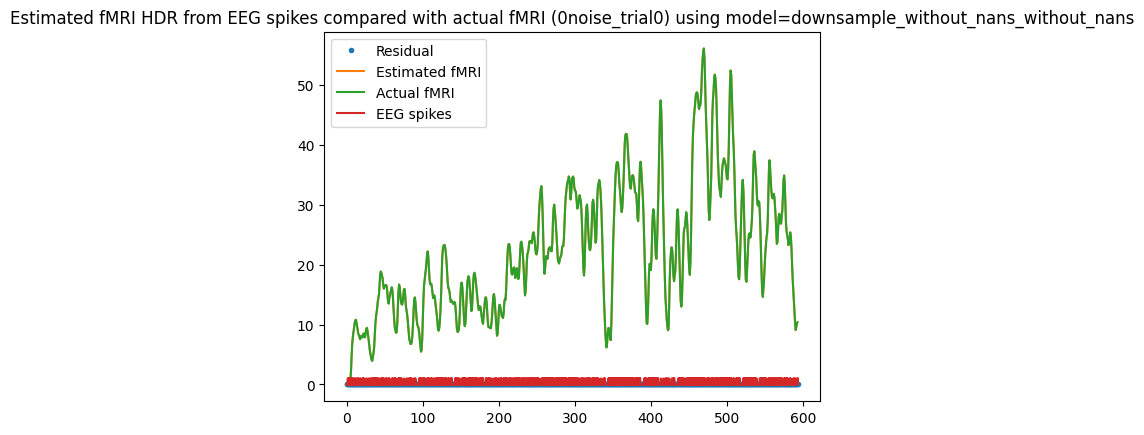

Residual Variance is 0.000000


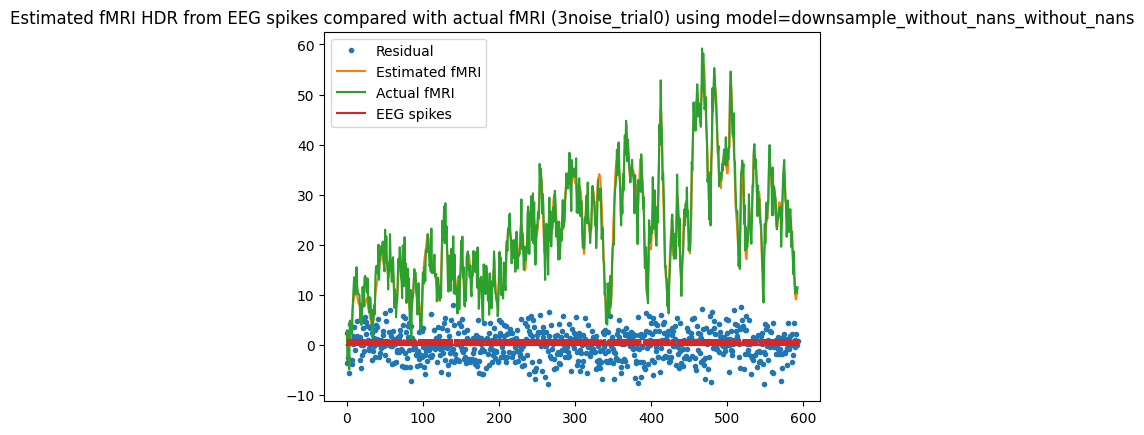

Residual Variance is 8.738564


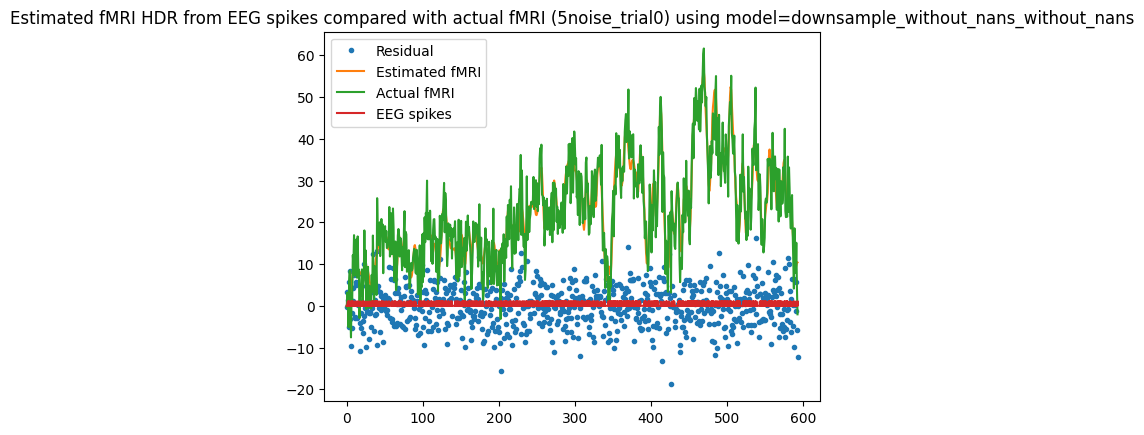

Residual Variance is 24.066621


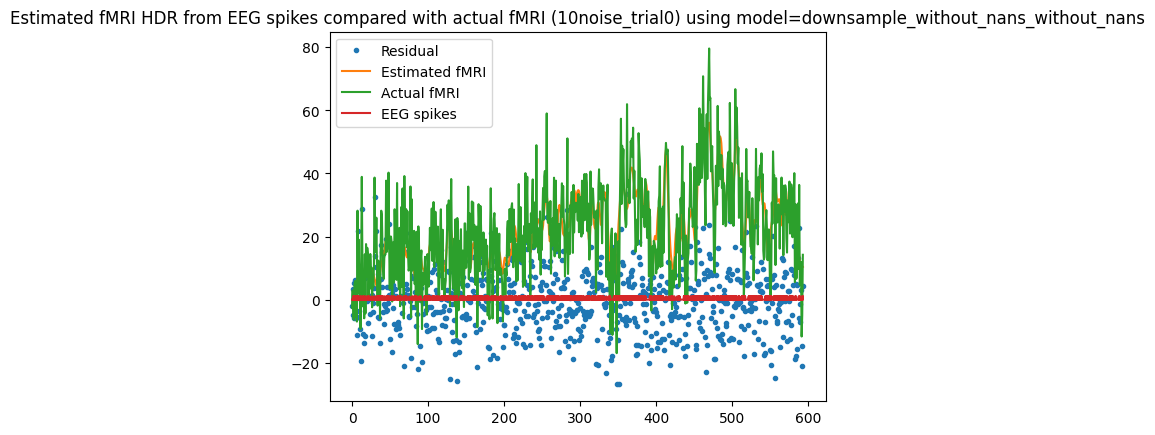

Residual Variance is 105.394090


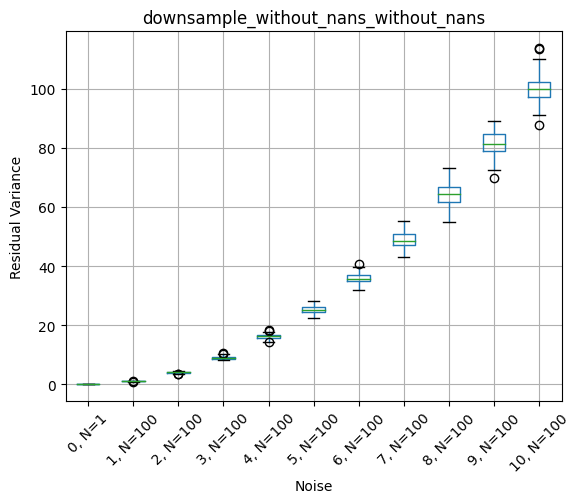

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.75, alpha=2


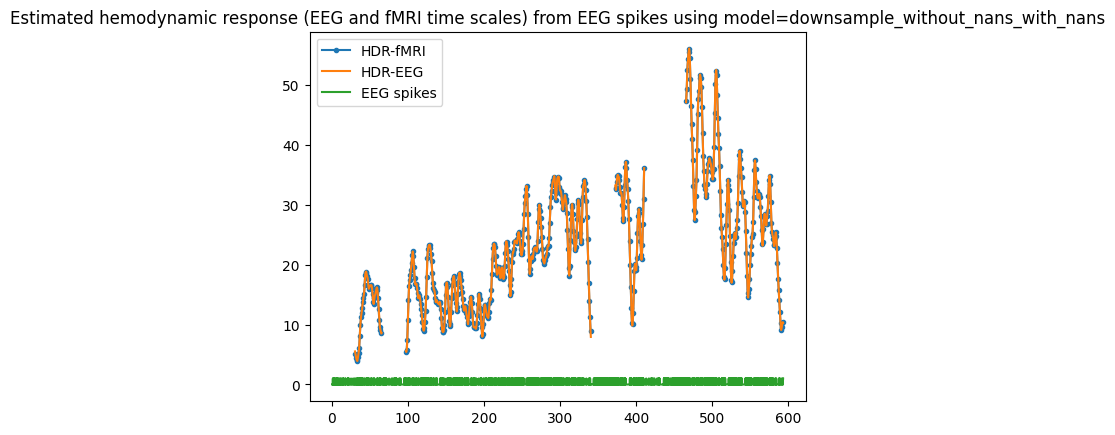

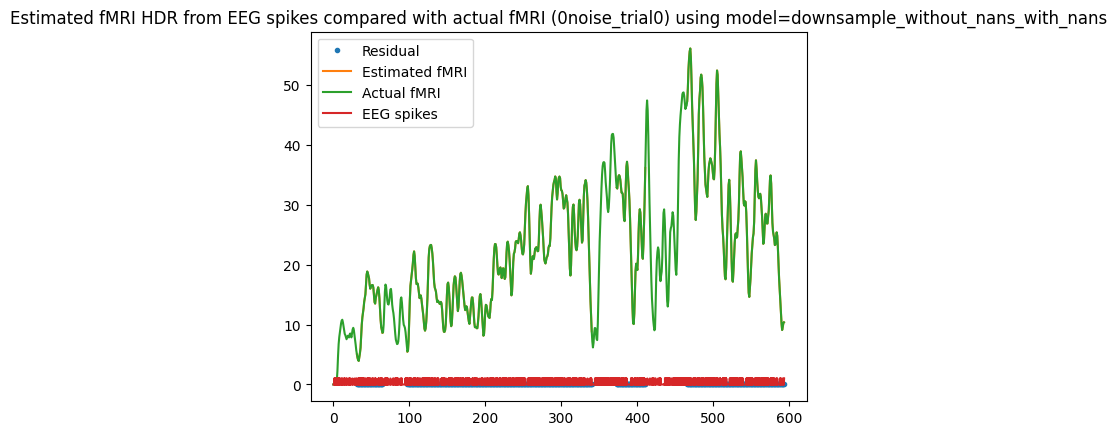

Residual Variance is 0.000000


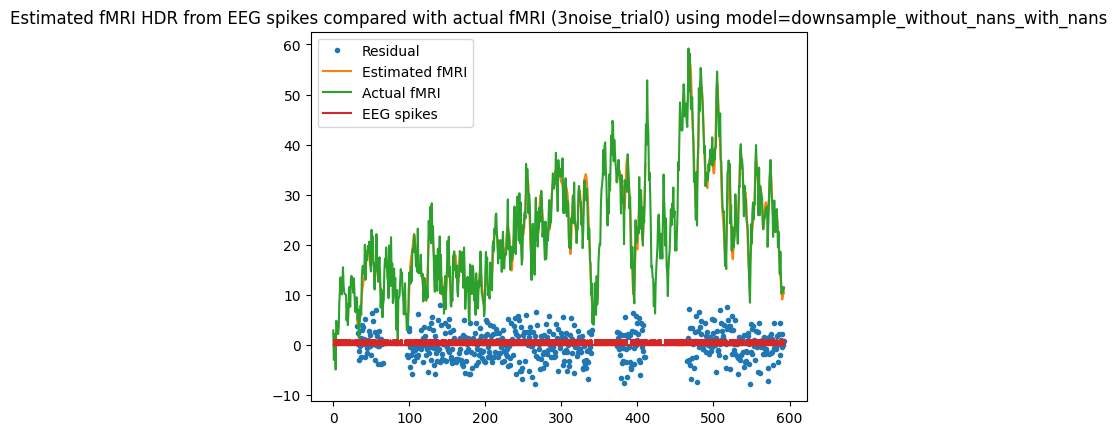

Residual Variance is 8.849365


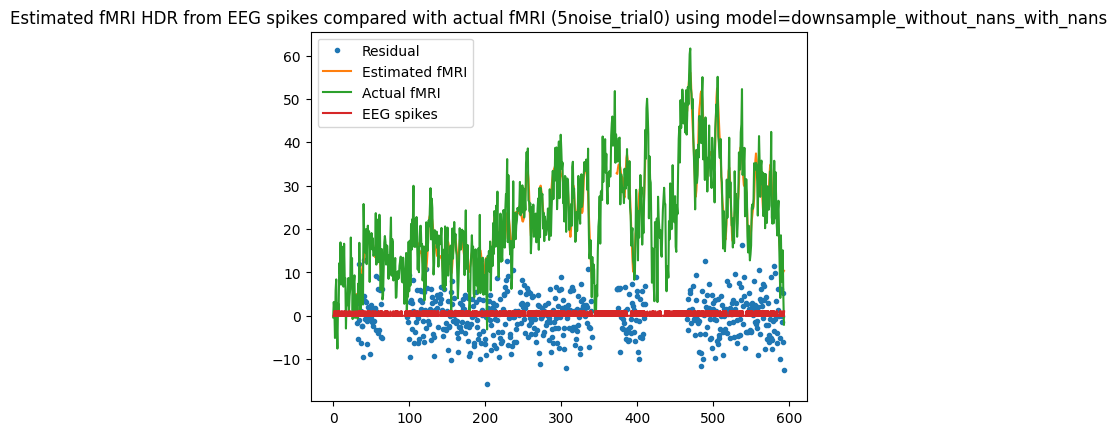

Residual Variance is 24.153897


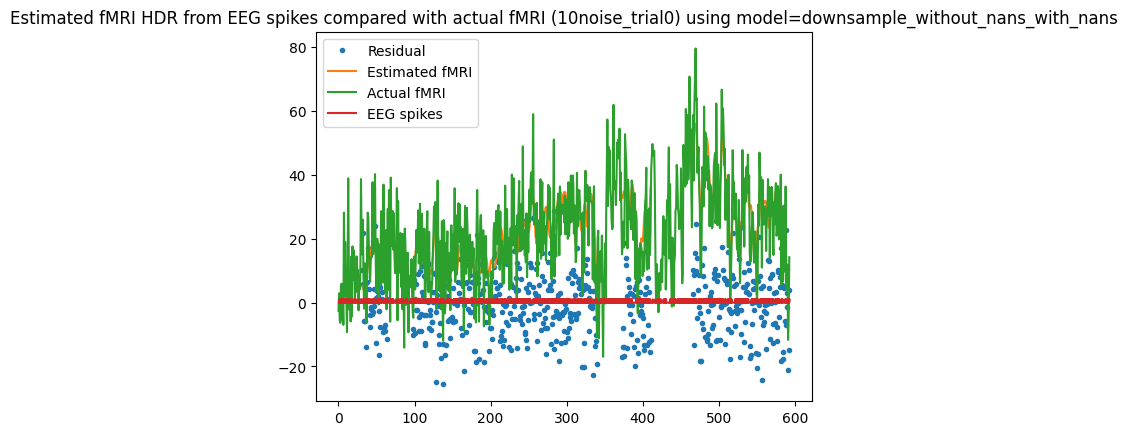

Residual Variance is 99.583217


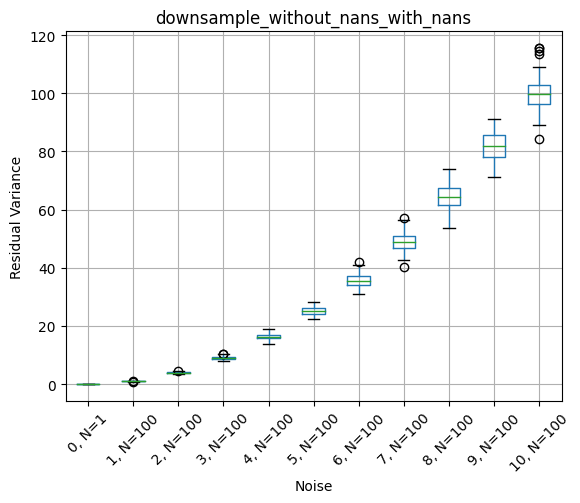

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   81.44043838271678   
1         downsample_without_nans_with_nans    72.7235188784778   
2      downsample_without_nans_without_nans   80.45581346483824   
3         downsample_without_nans_with_nans   71.90704655472192   
4      downsample_without_nans_without_nans   79.45768481576535   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   4.435088243130706   
18938  downsample_without_nans_without_nans   5.452537911583265   
18939     downsample_without_nans_with_nans  4.9931692195604604   
18940  downsample_without_nans_without_nans   6.111131876898811   
18941     downsample_without_nans_with_nans   5.576486711562483   

            1noise_trial0      2noise_trial0       3noise_trial0  \
0        83.3252687457086   83.0787839288748    86.5506056609299   
1       74.55543549281153  75.51955265510986   77.45748627902557   
2       82.34687206723194  82.13350916297337   85.62624646071023   
3       73.73830828854578  74.72903758130646   76.68619622937747   
4        81.3552197070249   81.1752502612003    84.6885313364629   
...                   ...                ...                 ...   
18937   5.066774758274612  8.568604318317032  13.414209493686155   
18938   5.981314180168857  9.256732684989103  13.893973949686687   
18939  5.6024489363278995  9.079149440795343  13.967166379175513   
18940    6.61635868044031  9.884138854895367  14.522683064250735   
18941   6.165198165966018  9.615455447967921  14.542092288682761   

            4noise_trial0       5noise_trial0  ...     1noise_trial99  \
0       96.77478347233934  102.54523608858905  ...   82.7622146344192   
1       89.32953914571196    91.9484113289894  ...  74.55319272591765   
2       95.77126787740899  101.53712846990982  ...  81.78582832370371   
3       88.49681874634561   91.12887390118635  ...  73.74171076507798   
4       94.75528410539516   100.5186070230939  ...  80.79523273289166   
...                   ...                 ...  ...                ...   
18937   19.72235109899347  28.244045463207446  ...  5.270240955819052   
18938   21.21906587786293   29.08302544378872  ...  6.386089546221315   
18939   20.24009202436341   28.71049067637874  ...  5.825268186836829   
18940  21.835922402657452  29.627168097925583  ...  7.047809191643927   
18941  20.784206561729636  29.199596252845993  ...  6.406207854655088   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       84.11943633688094   91.55003703799008   92.76219207400922   
1       75.21988684379157   82.44264974539917   84.45316642075724   
2       83.14662933891178   90.57048328289545   91.75494775633021   
3       74.42354880446571   81.62306586850164   83.61185651275702   
4       82.16067192228353   89.57729350629587   90.73780634887297   
...                   ...                 ...                 ...   
18937   9.004473295711273   12.53031579395736   19.57488658368834   
18938   10.11590023967108  13.450976651279309  21.010832151616356   
18939   9.573194852998189  13.049541782202654  20.153338119669538   
18

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.226660115237538e-28; at
       delta   tau  alpha
12000   2.25  1.75    2.0


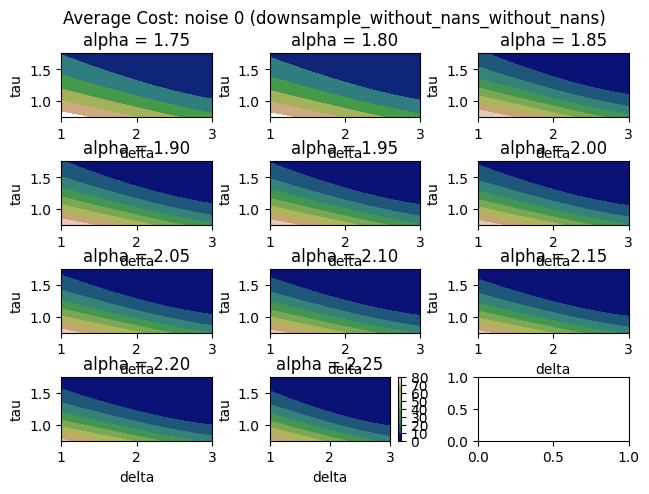

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              81.440438             
2                                              80.455813             
4                                              79.457685             
6                                              78.446485             
8                                              77.422670             
...                                                  ...             
18932                                           3.671946             
18934                                           4.230387             
18936                                           4.824784             
18938                                           5.452538             
18940                                           6.111132             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.75, Alpha target: 2


delta   tau  alpha
0   2.25  1.75    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  7.576647e-03   2.10  1.65   2.25
1      0         0  2.289880e-03   2.20  1.70   2.10
2      0         0  1.226660e-28   2.25  1.75   2.00

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
2      0         0  1.226660e-28   2.25  1.75    2.0

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.007577    2.1  1.65   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.4601259016123683e-27; at
       delta   tau  alpha
12001   2.25  1.75    2.0


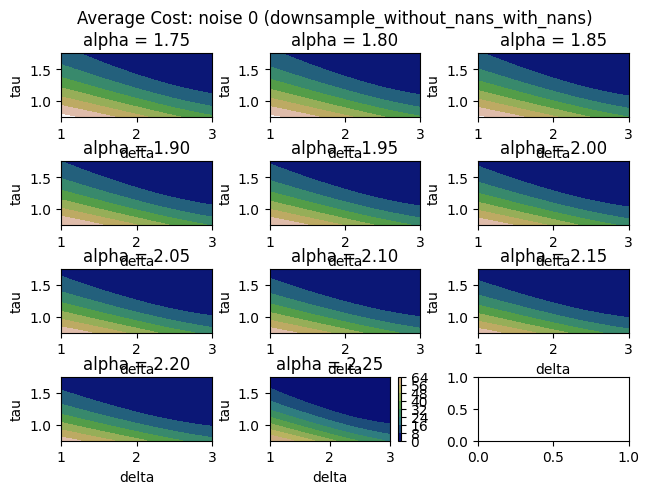

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              72.723519          
3                                              71.907047          
5                                              71.076496          
7                                              70.232148          
9                                              69.374310          
...                                                  ...          
18933                                           3.404532          
18935                                           3.904694          
18937                                           4.435088          
18939                                           4.993169          
18941                                           5.576487          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.75, Alpha target: 2


delta   tau  alpha
0   2.25  1.75    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  7.253878e-03   2.10  1.65   2.25
1      0         0  2.080133e-03   2.20  1.70   2.10
2      0         0  1.460126e-27   2.25  1.75   2.00

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
2      0         0  1.460126e-27   2.25  1.75    2.0

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.007254    2.1  1.65   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9941239771866944; at
       delta   tau  alpha
12000   2.25  1.75    2.0


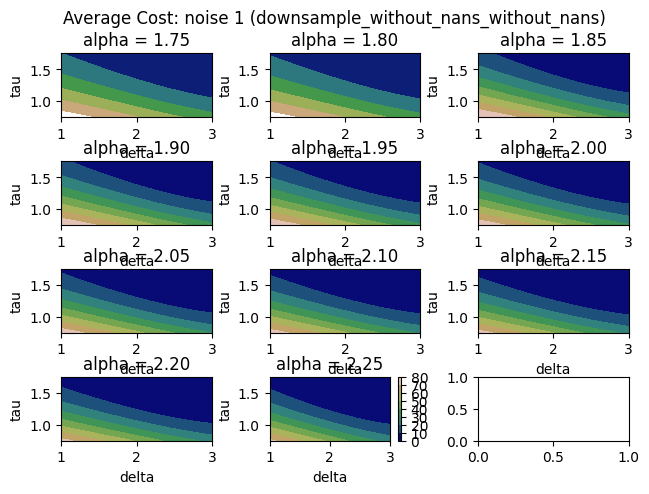

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.0101597433955; at
       delta   tau  alpha
12000   2.25  1.75    2.0


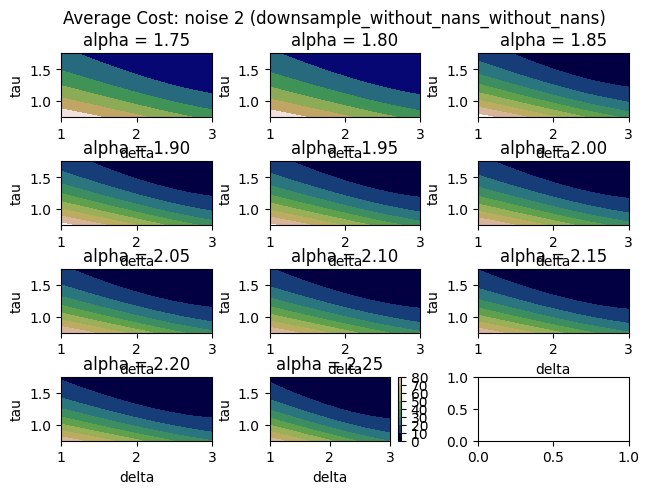

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.010509000486756; at
       delta   tau  alpha
12000   2.25  1.75    2.0


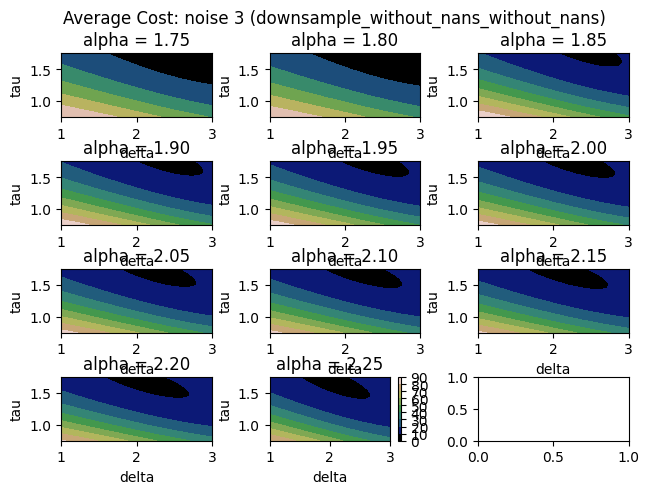

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.20559243261636; at
       delta   tau  alpha
12000   2.25  1.75    2.0


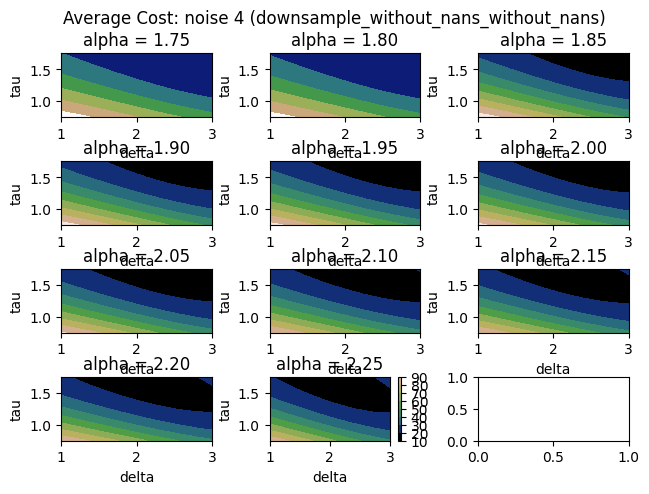

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.229423269911905; at
       delta   tau  alpha
12000   2.25  1.75    2.0


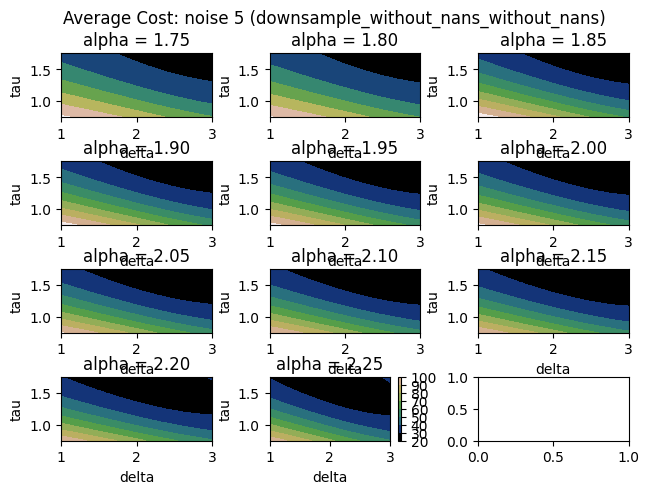

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.864173053421716; at
       delta  tau  alpha
11520    2.2  1.7    2.1


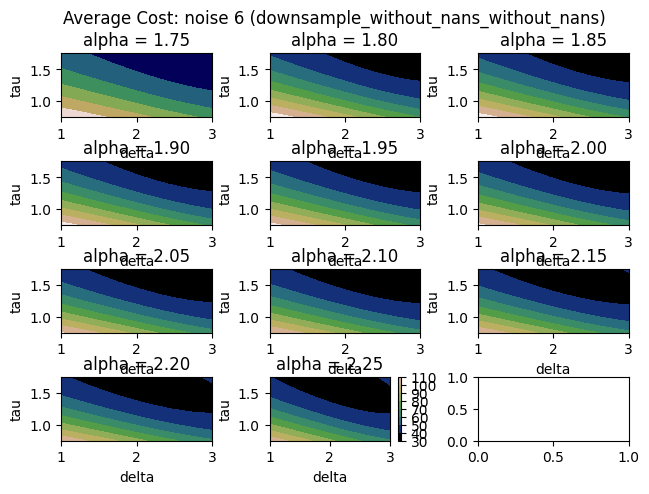

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.036433159837706; at
       delta   tau  alpha
12000   2.25  1.75    2.0


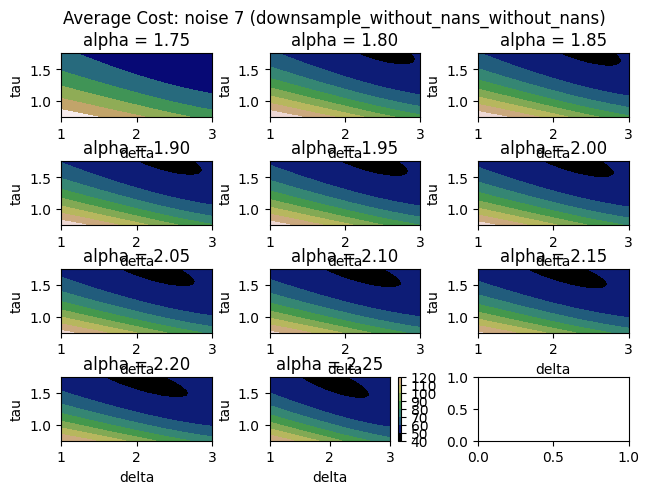

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.27561966402556; at
       delta  tau  alpha
11060   2.15  1.7   2.15


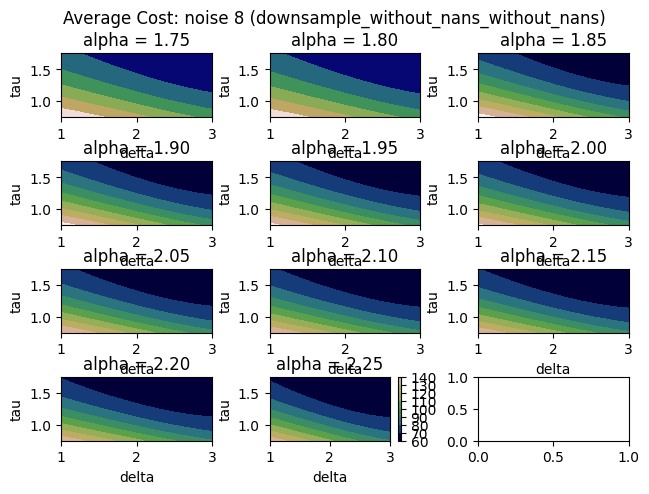

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.46669326193881; at
       delta   tau  alpha
12000   2.25  1.75    2.0


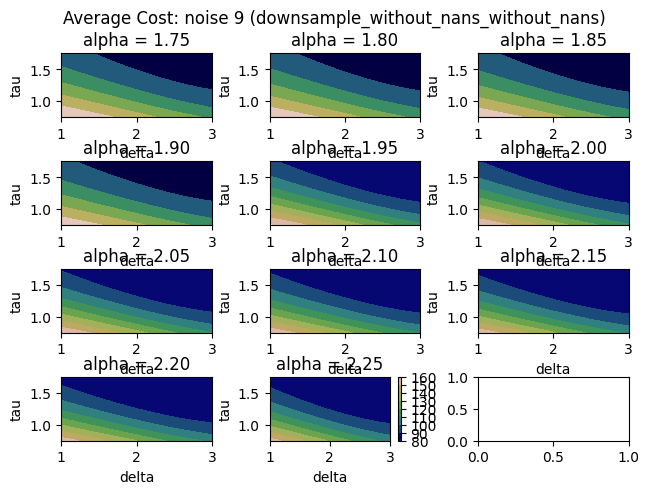

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.84939027897852; at
       delta  tau  alpha
11520    2.2  1.7    2.1


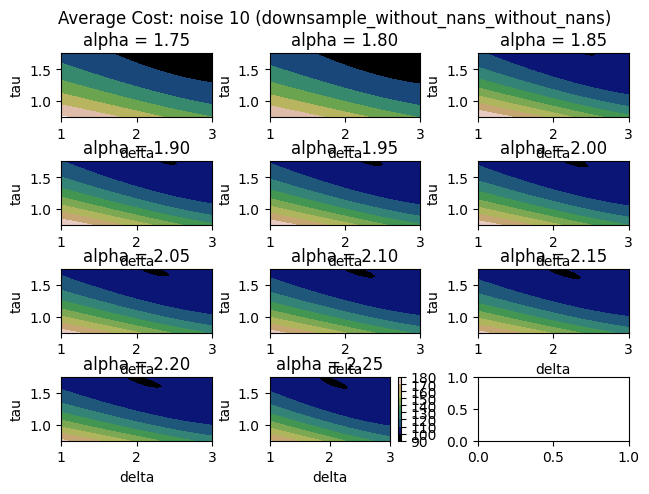

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

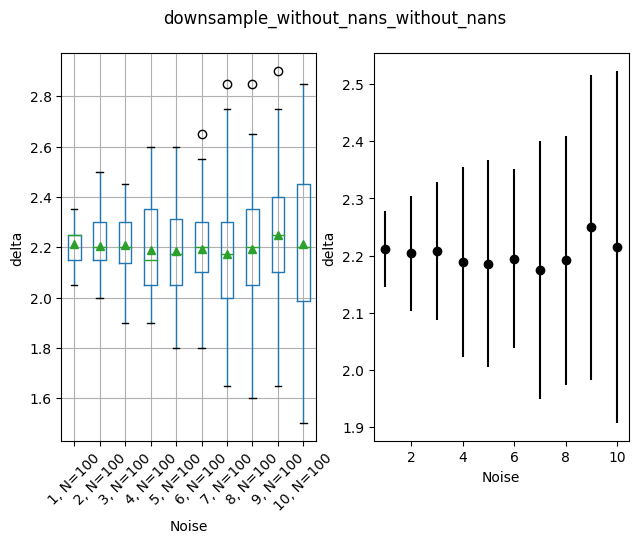

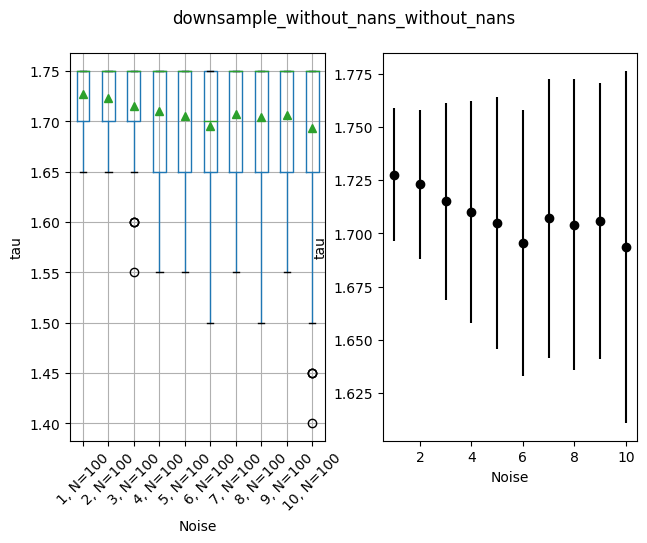

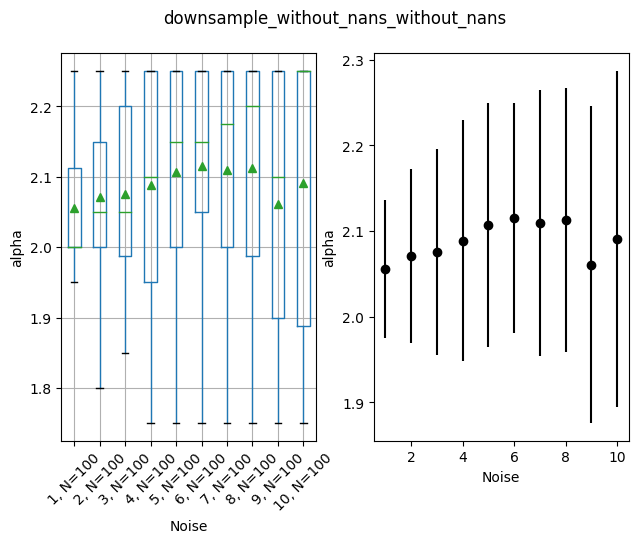

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9934532704488087; at
       delta   tau  alpha
12001   2.25  1.75    2.0


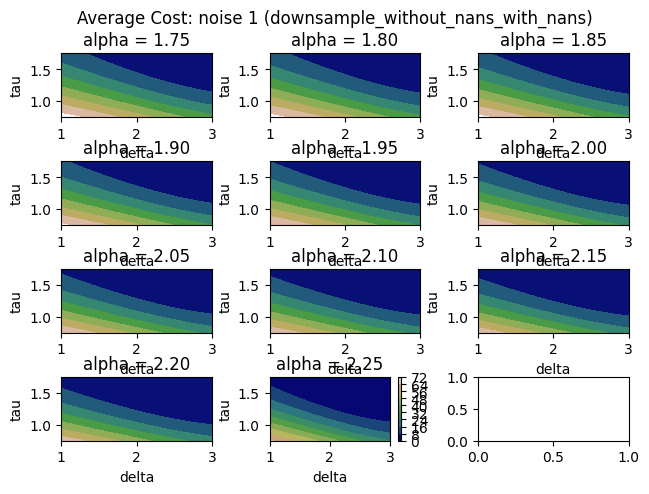

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.999276970084634; at
       delta   tau  alpha
12001   2.25  1.75    2.0


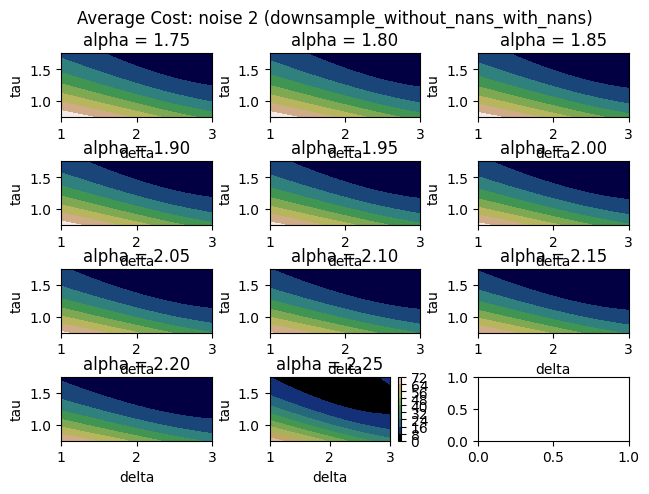

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.985091968861346; at
       delta   tau  alpha
12001   2.25  1.75    2.0


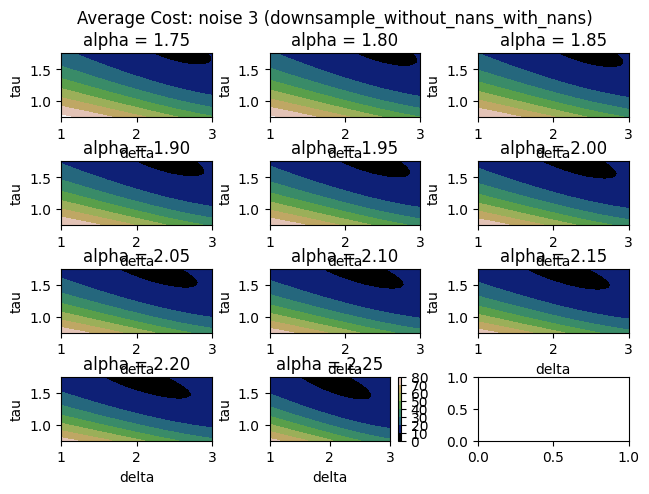

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.303917127170806; at
       delta   tau  alpha
12001   2.25  1.75    2.0


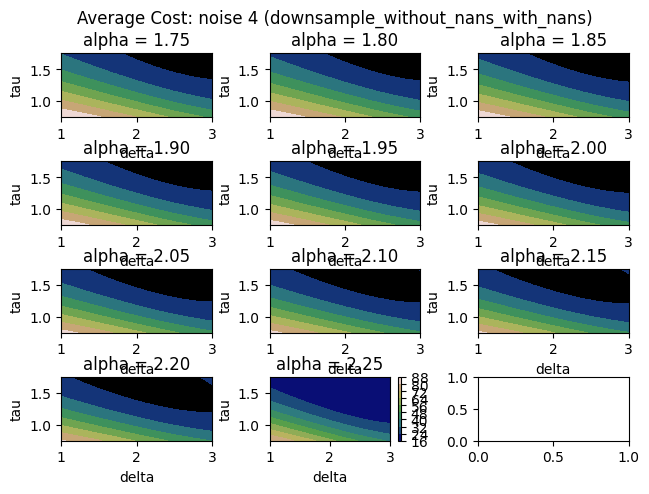

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.264303817660785; at
       delta   tau  alpha
12001   2.25  1.75    2.0


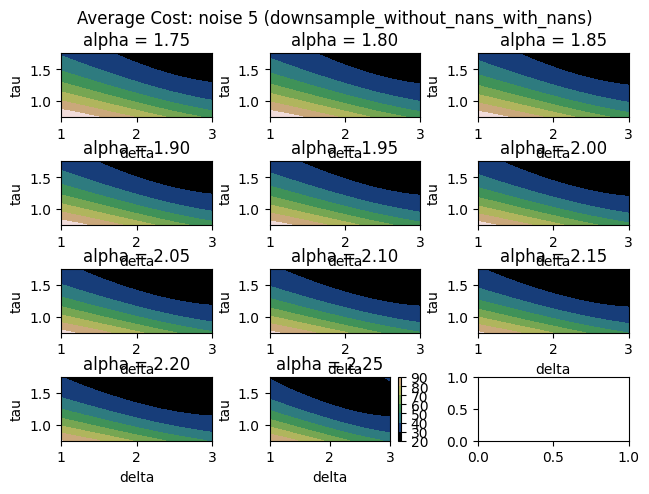

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.728249826384356; at
       delta   tau  alpha
12001   2.25  1.75    2.0


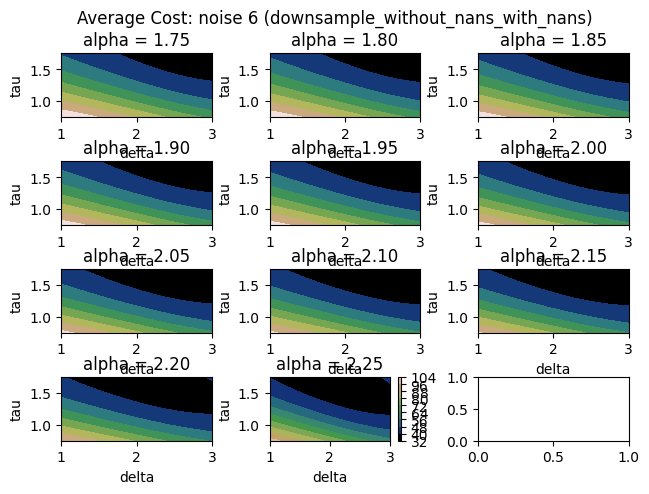

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.07660293765367; at
       delta   tau  alpha
12001   2.25  1.75    2.0


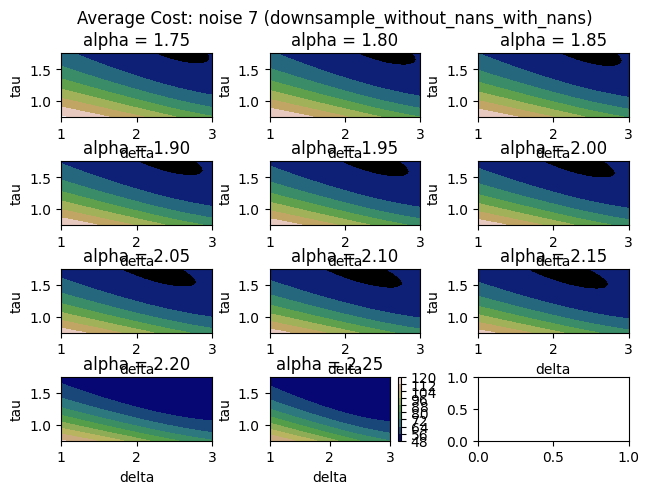

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.42690086958991; at
       delta  tau  alpha
11061   2.15  1.7   2.15


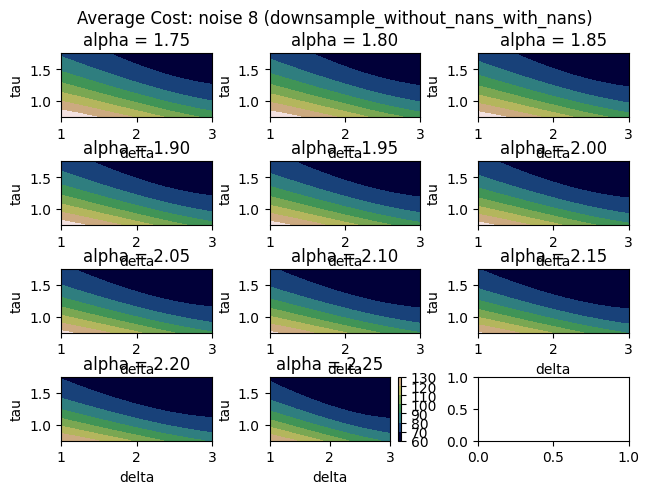

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.56805190705676; at
       delta   tau  alpha
12923   2.35  1.75   1.95


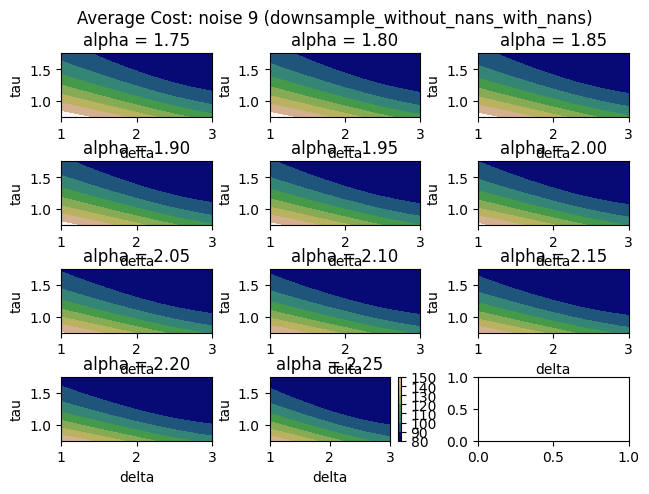

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.74947102869248; at
       delta  tau  alpha
11521    2.2  1.7    2.1


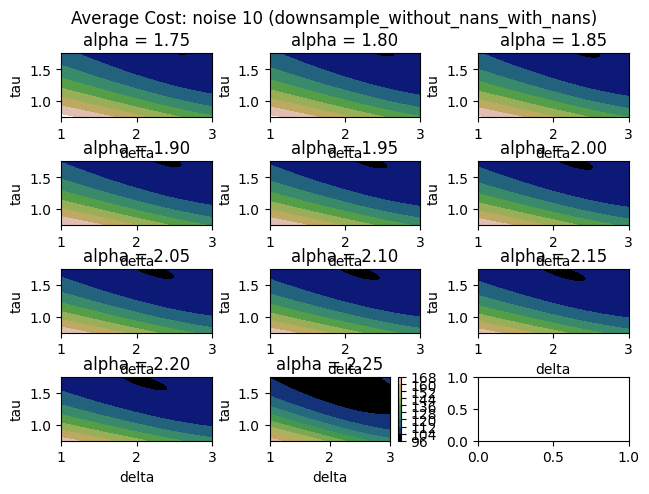

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


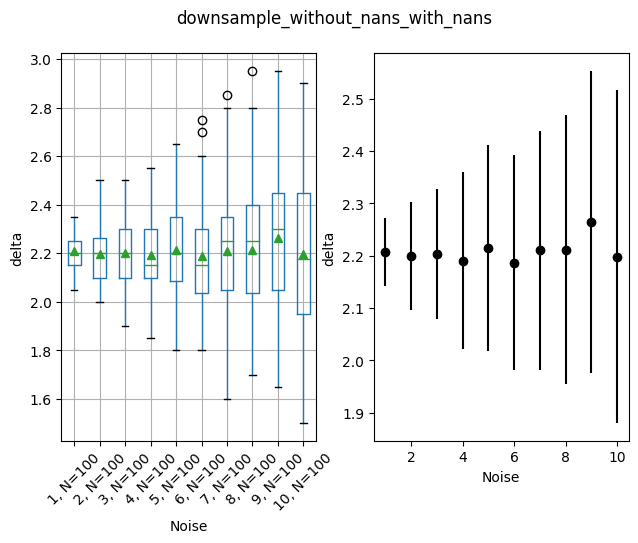

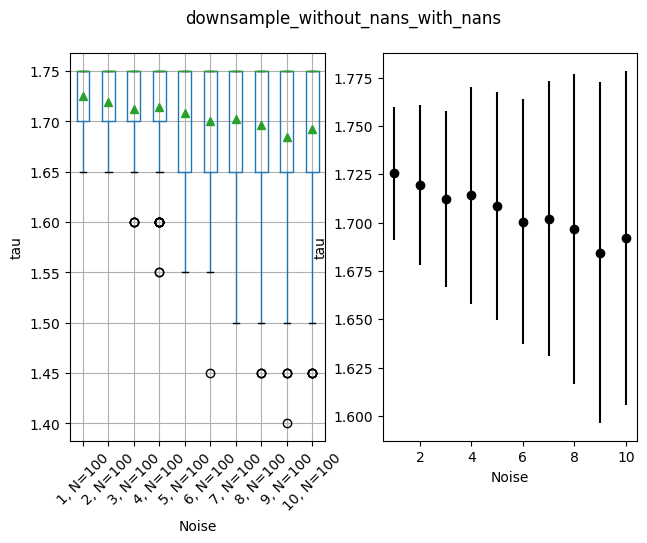

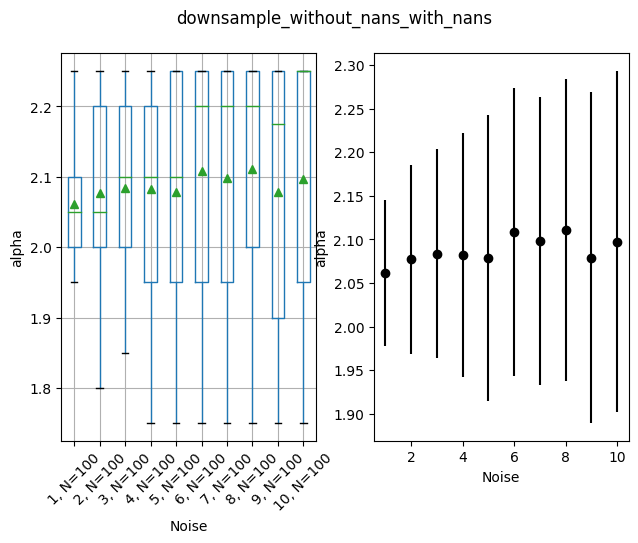

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        97    0.989820   2.000000000000001  1.7000000000000008   
1         1        16    0.922298  2.0500000000000007  1.6500000000000008   
2         1        18    0.996498  2.0500000000000007  1.6500000000000008   
3         1        21    0.961745  2.0500000000000007  1.6500000000000008   
4         1        25    0.988368  2.0500000000000007  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
2317     10        16  106.997320  2.7500000000000018  1.6500000000000008   
2318     10        55   91.653324  2.7500000000000018  1.6500000000000008   
2319     10        36   98.616972  2.8000000000000016  1.7500000000000009   
2320     10        37  106.562929  2.8500000000000014  1.7500000000000009   
2321     10        36   98.621573  2.9000000000000017  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2317                1.75  
2318                1.75  
2319                 1.8  
2320                1.75  
2321                1.75  

[2322 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.08  0.691653  1.0  3.0  3.0  4.00  4.0
2                      100.0  2.93  0.912926  1.0  2.0  3.0  3.25  5.0
3                      100.0  2.81  0.906709  1.0  2.0  3.0  3.00  6.0
4                      100.0  2.48  1.114460  1.0  2.0  2.0  3.00  5.0
5                      100.0  2.28  1.215057  1.0  1.0  2.0  3.00  5.0
6                      100.0  2.30  1.159066  1.0  1.0  2.0  3.00  6.0
7                      100.0  1.94  1.126539  1.0  1.0  2.0  3.00  6.0
8                      100.0  1.89  1.171160  1.0  1.0  1.0  3.00  6.0
9                      100.0  1.79  1.103667  1.0  1.0  1.0  2.00  5.0
10                     100.0  1.72  0.985552  1.0  1.0  1.0  2.00  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
133       1         1    0.957707  2.1500000000000012  1.7500000000000009   
134       1        15    0.945384  2.1500000000000012  1.7500000000000009   
135       1        21    0.956773  2.1500000000000012  1.7500000000000009   
136       1        26    0.982202  2.1500000000000012  1.7500000000000009   
137       1        28    0.949136  2.1500000000000012  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
2315     10        88   97.536345  2.7000000000000015  1.7500000000000009   
2316     10        56  101.062623  2.7000000000000015  1.7500000000000009   
2319     10        36   98.616972  2.8000000000000016  1.7500000000000009   
2320     10        37  106.562929  2.8500000000000014  1.7500000000000009   
2321     10        36   98.621573  2.9000000000000017  1.7500000000000009   

                   alpha  
133   2.0500000000000003  
134   2.0500000000000003  
135   2.0500000000000003  
136   2.0500000000000003  
137   2.0500000000000003  
...                  ...  
2315                 1.8  
2316                1.85  
2319                 1.8  
2320                1.75  
2321                1.75  

[985 rows x 6 columns]

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
1120      4        24   16.138416  2.5000000000000013  1.7500000000000009   
1129      4         9   15.351270  2.6000000000000014  1.7500000000000009   
1340      5        63   25.126410  2.5000000000000013  1.7500000000000009   
1348      5        37   25.546360  2.5500000000000016  1.7500000000000009   
1354      5         1   22.186605  2.6000000000000014  1.7500000000000009   
1576      6        37   40.483543  2.5000000000000013  1.7500000000000009   
1577      6        38   35.361934  2.5000000000000013  1.7500000000000009   
1578      6        73   34.770032  2.5000000000000013  1.7500000000000009   
1583      6         2   36.365876  2.5500000000000016  1.7500000000000009   
1586      6        25   36.673771  2.6000000000000014  1.7500000000000009   
1755      7        26   45.542437   2.450000000000001  1.7500000000000009   
1763      7        46   48.866603  2.5000000000000013  1.7500000000000009   
1774      7        28   49.989745  2.6500000000000012  1.7500000000000009   
1778      7         7   48.612198  2.7500000000000018  1.7500000000000009   
1780      7        21   46.110583  2.8000000000000016  1.7500000000000009   
1781      7        22   54.557607  2.8500000000000014  1.6000000000000008   
1962      8        99   68.762714  2.6500000000000012  1.6500000000000008   
1963      8        49   61.820672  2.6500000000000012  1.7000000000000008   
1966      8        50   59.381375  2.8000000000000016  1.6500000000000008   
1969      8        53   68.074664  2.8500000000000014  1.7000000000000008   
1970      8        63   72.596777  2.8500000000000014  1.7000000000000008   
2094      9        28   82.174561  2.4000000000000012  1.7500000000000009   
2095      9        65   72.298505  2.4000000000000012  1.7500000000000009   
2111      9        85   78.623052   2.450000000000001  1.7500000000000009   
2118      9        54   77.801204  2.5000000000000013  1.7500000000000009   
2124      9        99   81.102386  2.5500000000000016  1.7000000000000008   
2125      9        55   84.966873  2.5500000000000016  1.7500000000000009   
2131      9        61   85.720942  2.6000000000000014  1.7500000000000009   
2132      9        31   86.369701  2.6500000000000012  1.6000000000000008   
2134      9        24   85.332493  2.6500000000000012  1.7000000000000008   
2135      9        89   79.106240  2.6500000000000012  1.7000000000000008   
2140      9         5   79.315104  2.7000000000000015  1.6500000000000008   
2141      9        57   77.076711  2.7000000000000015  1.7500000000000009   
2142      9        98   82.983842  2.7000000000000015  1.7500000000000009   
2144      9        49   86.826779  2.7500000000000018  1.7000000000000008   
2145      9        96   88.062288  2.7500000000000018  1.7000000000000008   
2147      9        67   80.990942  2.8000000000000016  1.7000000000000008   
2248     10        19  100.351299   2.300000000000001  1.7500000000000009   
2270     10        14   97.500944  2.4000000000000012  1.7500000000000009   
2298     10        17  102.955893  2.5500000000000016  1.7500000000000009   
2304     10        61   98.694397  2.6000000000000014  1.6500000000000008   
2305     10        27  100.340463  2.6000000000000014  1.7000000000000008   
2306     10        80  103.953029  2.6000000000000014  1.7000000000000008   
2310     10        11  101.920092  2.6500000000000012  1.7500000000000009   
2317     10        16  106.997320  2.7500000000000018  1.6500000000000008   
2318     10        55   91.653324  2.7500000000000018  1.6500000000000008   
2320     10        37  106.562929  2.8500000000000014  1.7500000000000009   
2321     10        36   98.621573  2.9000000000000017  1.7500000000000009   

     alpha  
1120  1.75  
1129  1.75  
1340  1.75  
1348  1.75  
1354  1.75  
1576  1.75  
1577  1.75  
1578  1.75  
1583  1.75  
1586  1.75  
1755  1.75  
1763  1.75  
1774  1.75  
1778  1.75  
1780  1.75  
1781  1.75  
1962  1.75 

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10       11      8  2.6000000000000014    3    11      3  1.7500000000000009   
4         2      2  2.5000000000000013    1     2      1  1.7500000000000009   
5         3      3  2.5000000000000013    1     3      1  1.7500000000000009   
6         5      3  2.5000000000000013    3     5      1  1.7500000000000009   
7         6      6   2.450000000000001    1     6      2  1.7500000000000009   
8         5      3  2.6500000000000012    2     5      2  1.7000000000000008   
9        16      9  2.6500000000000012    3    16      4  1.7500000000000009   

            
      freq  
noise       
10       6  
4        2  
5        3  
6        5  
7        5  
8        3  
9        8

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        97    0.989820   2.000000000000001  1.7000000000000008   
1         1        16    0.922298  2.0500000000000007  1.6500000000000008   
2         1        18    0.996498  2.0500000000000007  1.6500000000000008   
3         1        21    0.961745  2.0500000000000007  1.6500000000000008   
4         1        25    0.988368  2.0500000000000007  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
2276     10        93  105.457815   2.450000000000001  1.5000000000000007   
2287     10        50   99.111002  2.5000000000000013  1.4500000000000006   
2288     10        47  113.195079  2.5000000000000013  1.5000000000000007   
2295     10        83   90.450697  2.5500000000000016  1.5000000000000007   
2307     10         0  104.307444  2.6500000000000012  1.4000000000000006   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2276  2.2500000000000004  
2287  2.2500000000000004  
2288  2.2500000000000004  
2295  2.2500000000000004  
2307  2.2500000000000004  

[500 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        59      3   2.100000000000001   41    59      2  1.6500000000000008   
10       65     21  1.8500000000000008    7    65      8  1.7500000000000009   
2        46      5   2.100000000000001   21    46      3  1.6500000000000008   
3        36      8   2.100000000000001   13    36      4  1.6500000000000008   
4        43      9  2.0500000000000007    9    43      5  1.6500000000000008   
5        51     12   2.100000000000001    9    51      5  1.6500000000000008   
6        52     12   2.100000000000001   11    52      6  1.7000000000000008   
7        53     16  1.9500000000000008   11    53      5  1.7500000000000009   
8        53     14  2.1500000000000012    8    53      6  1.6500000000000008   
9        42     16   2.100000000000001    7    42      6  1.7500000000000009   

            
      freq  
noise       
1       58  
10      21  
2       37  
3       21  
4       16  
5       14  
6       15  
7       15  
8       16  
9       12

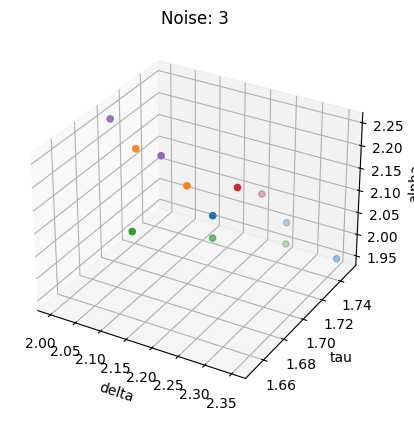

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

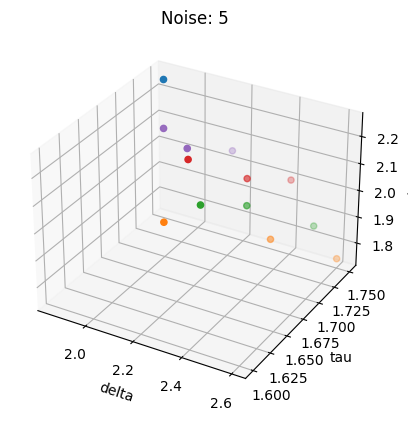

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

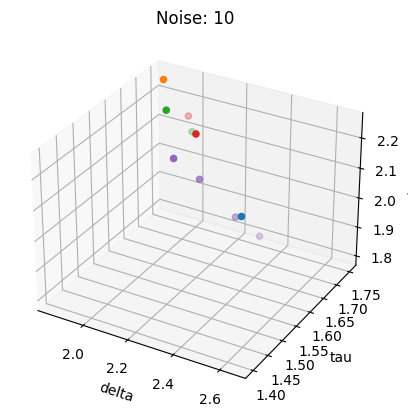

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration       cost               delta                 tau  \
0         1        97   1.010368   2.000000000000001  1.7000000000000008   
1         1         3   0.927757  2.0500000000000007  1.6500000000000008   
2         1         6   1.100366  2.0500000000000007  1.6500000000000008   
3         1         9   1.053863  2.0500000000000007  1.6500000000000008   
4         1        15   0.928956  2.0500000000000007  1.6500000000000008   
...     ...       ...        ...                 ...                 ...   
2075     10        12  97.529189  2.8000000000000016  1.6000000000000008   
2076     10        40  97.116886  2.8000000000000016  1.6500000000000008   
2077     10        36  99.125771  2.8000000000000016  1.7500000000000009   
2078     10        56  96.368268  2.8500000000000014  1.7500000000000009   
2079     10        55  90.891951  2.9000000000000017  1.6000000000000008   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2075                1.85  
2076                 1.8  
2077                1.75  
2078                1.85  
2079                1.75  

[2080 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.92  0.747791  1.0  2.0  3.0  3.0  4.0
2                      100.0  2.71  0.868006  1.0  2.0  3.0  3.0  5.0
3                      100.0  2.52  1.039425  1.0  2.0  2.0  3.0  5.0
4                      100.0  2.18  1.057728  1.0  1.0  2.0  3.0  5.0
5                      100.0  1.95  1.233988  1.0  1.0  1.0  3.0  6.0
6                      100.0  1.83  0.985296  1.0  1.0  2.0  2.0  5.0
7                      100.0  1.67  1.073604  1.0  1.0  1.0  2.0  5.0
8                      100.0  1.71  1.103667  1.0  1.0  1.0  2.0  6.0
9                      100.0  1.81  1.178040  1.0  1.0  1.0  2.0  6.0
10                     100.0  1.50  1.058873  1.0  1.0  1.0  2.0  6.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau  \
1929      9         6  84.413975  3.0000000000000018  1.5500000000000007   

                   alpha  
1929  1.9500000000000002

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
78        1        37    0.986907   2.100000000000001  1.7500000000000009   
124       1         1    0.941411  2.1500000000000012  1.7500000000000009   
125       1        15    0.928307  2.1500000000000012  1.7500000000000009   
126       1        25    0.965044  2.1500000000000012  1.7500000000000009   
127       1        28    0.948909  2.1500000000000012  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
2065     10        59  104.930823  2.6500000000000012  1.7500000000000009   
2066     10        11  105.262091  2.6500000000000012  1.7500000000000009   
2068     10        37  107.916648  2.7000000000000015  1.7500000000000009   
2077     10        36   99.125771  2.8000000000000016  1.7500000000000009   
2078     10        56   96.368268  2.8500000000000014  1.7500000000000009   

                   alpha  
78    2.1000000000000005  
124   2.0500000000000003  
125   2.0500000000000003  
126   2.0500000000000003  
127   2.0500000000000003  
...                  ...  
2065                1.75  
2066                 1.8  
2068                1.75  
2077                1.75  
2078                1.85  

[866 rows x 6 columns]

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
1022      4        24   16.793694  2.5000000000000013  1.7500000000000009   
1023      4        87   16.203981  2.5000000000000013  1.7500000000000009   
1029      4        29   16.072262  2.5500000000000016  1.7500000000000009   
1169      5        68   22.493634  2.3500000000000014  1.7500000000000009   
1200      5        57   24.141889   2.450000000000001  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
2065     10        59  104.930823  2.6500000000000012  1.7500000000000009   
2068     10        37  107.916648  2.7000000000000015  1.7500000000000009   
2074     10        16  112.380307  2.8000000000000016  1.6000000000000008   
2077     10        36   99.125771  2.8000000000000016  1.7500000000000009   
2079     10        55   90.891951  2.9000000000000017  1.6000000000000008   

     alpha  
1022  1.75  
1023  1.75  
1029  1.75  
1169  1.75  
1200  1.75  
...    ...  
2065  1.75  
2068  1.75  
2074  1.75  
2077  1.75  
2079  1.75  

[61 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10       18     12  2.6500000000000012    4    18      4  1.7500000000000009   
4         3      2  2.5000000000000013    2     3      1  1.7500000000000009   
5        10      7  2.5000000000000013    2    10      1  1.7500000000000009   
6         5      4  2.6000000000000014    2     5      2  1.7500000000000009   
7         3      3  2.7000000000000015    1     3      3  1.7000000000000008   
8        10      8   2.450000000000001    2    10      2  1.7500000000000009   
9        12      9   2.450000000000001    2    12      5  1.7500000000000009   

            
      freq  
noise       
10      10  
4        3  
5       10  
6        3  
7        1  
8        7  
9        5

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration       cost               delta                 tau  \
0         1        97   1.010368   2.000000000000001  1.7000000000000008   
1         1         3   0.927757  2.0500000000000007  1.6500000000000008   
2         1         6   1.100366  2.0500000000000007  1.6500000000000008   
3         1         9   1.053863  2.0500000000000007  1.6500000000000008   
4         1        15   0.928956  2.0500000000000007  1.6500000000000008   
...     ...       ...        ...                 ...                 ...   
2040     10        34  98.550215  2.5000000000000013  1.4500000000000006   
2041     10        89  93.792879  2.5000000000000013  1.5000000000000007   
2047     10        12  97.507002  2.5500000000000016  1.4500000000000006   
2056     10        79  88.997868  2.6500000000000012  1.4000000000000006   
2057     10        83  88.743890  2.6500000000000012  1.4500000000000006   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2040  2.2500000000000004  
2041  2.2500000000000004  
2047  2.2500000000000004  
2056  2.2500000000000004  
2057  2.2500000000000004  

[501 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        52      4   2.100000000000001   31    52      2  1.6500000000000008   
10       63     22  1.9500000000000008    9    63      8  1.7500000000000009   
2        44      4   2.100000000000001   20    44      3  1.6500000000000008   
3        37      8   2.100000000000001   15    37      4  1.6500000000000008   
4        42     12   2.000000000000001    8    42      5  1.7000000000000008   
5        45     13   2.000000000000001    6    45      5  1.6500000000000008   
6        51     13  2.1500000000000012   11    51      6  1.7000000000000008   
7        54     14   2.250000000000001    8    54      6  1.7500000000000009   
8        57     20  2.1500000000000012    7    57      7  1.7500000000000009   
9        56     18  2.0500000000000007    6    56      8  1.7500000000000009   

            
      freq  
noise       
1       51  
10      27  
2       35  
3       18  
4       13  
5       13  
6       16  
7       17  
8       20  
9       13

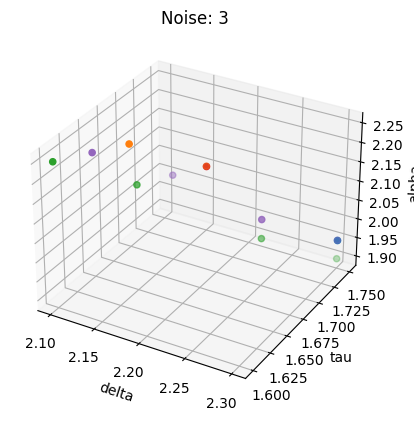

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

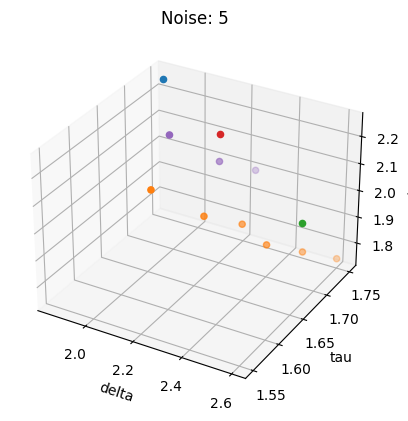

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

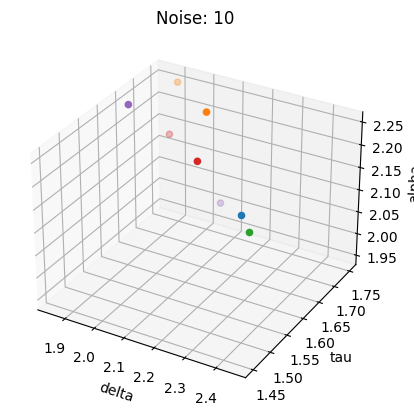

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()